In [2]:
import requests
import os
import json
import pandas as pd
import numpy as np
import pickle as pkl
import TwitterUtils as TU
import seaborn as sns
import re

# import spacy
# import spacy_langdetect as sld

## Combining Data

The `GetPlaces.py`, `GetTweets.py`, and `SampleUser.py` files have generated the following output files:
* `users.json` : contains all the user specific data from the 51,000 sampled users
* `places.pkl` : metadata related to all twitter places in the user sample
* `tweets.pkl` : retrieved 100 tweets from each user
* `user_data_convo.pkl` : For each tweet, we have collected up to 50 related texts in the same thread, sorted by order

In [1]:
URL_regex = 'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&\/\/=]*)'
twitter_username_re = '(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)'
twitter_username_re = r"((^|[^@\w])@(\w{1,15})\b)*"

In [3]:
with open("places.pkl", "rb") as file: # Unique Places
    places = pkl.load(file)

with open('tweets.pkl', 'rb') as file: # Rename to Tweets, user_id, place_id
    data = pkl.load(file)

with open('users.json', 'r') as file: # Actual data for user accounts
    user_json = file.read()

test = '{"total": [' + user_json.replace("}{", "},{") + "]}"
user_data = json.loads(test)
users = [u['data'] for u in user_data["total"]]
flat_list = [user_id for user in users for user_id in user]

with open("user_data_convo.pkl", "rb") as file:
    convos = pkl.load(file)

with open("timestamps.pkl", "rb") as file:
    timestamps = pkl.load(file)


In [4]:
timestamp_data = [t['data'] for t in timestamps]
ts_list = []

for t in timestamp_data:
    ts_list = ts_list + [*t]

In [5]:
places_unpacked = [item  for item in places.values()]
def unpack_place(place):
    return (place.id, place.name, place.full_name, place.country, place.country_code, place.place_type, place.centroid[0], place.centroid[1])

unpacked_places = [unpack_place(place) for place in places_unpacked]
place_df = pd.DataFrame(unpacked_places, columns = ("id", "name", "full_name", "country", "country_code", "type", "lat", "lon"))
users_df = pd.DataFrame(flat_list).rename(columns = {'name' : 'user_name_field'})
convo_df = pd.DataFrame(convos)
ts_df = pd.DataFrame(ts_list) # For merging with convo dataset
data_df = pd.DataFrame(data)

While the approach below does provide a more foolproof ordering, the limitation is that it is difficult to map the conversations to place ids / users, as some may not be in the dataset. A second approach exploits the fact that tweet ids are strictly increasing, so order can be inferred from there

In [6]:
convo_dict = {}

for tsl in ts_list:
    if convo_dict.get(tsl['conversation_id']):
        convo_dict[tsl['conversation_id']].append(tsl)
    else:
        convo_dict[tsl['conversation_id']] = [tsl]

for entry in convo_dict:
    convo_dict[entry].sort(key=lambda x: x['created_at'])

In [7]:
merged = convo_df.merge(ts_df[['id', 'created_at']], how = 'left', left_on = 'tweet_id', right_on = 'id')
test = merged.merge(users_df, how = 'left', left_on = 'user_id', right_on ='id' )
test = test.drop(columns = ['id_x', 'id_y'])
test2 = test.merge(data_df[['tweet_id', 'place_id']], how = 'left', left_on = 'tweet_id', right_on = 'tweet_id')
with_places = test2.merge(place_df, how = 'left', left_on = 'place_id', right_on = 'id')
with_places_list = with_places.to_dict('records')

To include place_id, we iterate over all records and aggregate by convo_id. Then, we assign the only non-null place_id to the entire conversation

In [8]:
convo_dict_location = {}

for wpl in with_places_list:
    if convo_dict_location.get(wpl['convo_id']):
        convo_dict_location[wpl['convo_id']]['tweets'].append(wpl)
    else:
        convo_dict_location[wpl['convo_id']] = {}
        convo_dict_location[wpl['convo_id']]['tweets'] = [wpl]
    if not pd.isna(wpl['place_id']):
        convo_dict_location[wpl['convo_id']]['place_id'] = wpl['place_id']
        


In [15]:
for entry in convo_dict_location:
    convo_dict_location[entry]['tweets'] = pd.DataFrame(convo_dict_location[entry]['tweets']).drop_duplicates(subset = 'tweet_id').to_dict('records')
    convo_dict_location[entry]['tweets'].sort(key=lambda x: x['tweet_id'])
    joined_tweets = []
    user_ids = []
    last_id = "Blank"
    for tweet in convo_dict_location[entry]['tweets']:
        if last_id == tweet['user_id']:
            user_string = " "
            joined_tweets[-1] = joined_tweets[-1][:-2] # Remove delimiter || for new person talking
        else:
            user_string = '[' + tweet['user_id'] + ']: ' 
            last_id = tweet['user_id'] 

        joined_tweets.append(user_string + tweet['tweet_text'] + ' ||')
        user_ids.append(tweet['user_id'])
    convo_dict_location[entry]['tweet_list'] = joined_tweets
    convo_dict_location[entry]['user_list'] = list(set(user_ids))
    convo_dict_location[entry]['tweet_joined'] = " ".join(joined_tweets)
    for user in convo_dict_location[entry]['user_list']:
        # Rather than having user_ids in the prompt themselves, we want to have numbers representing the participants in the dialogue
        convo_dict_location[entry]['tweet_joined'] = convo_dict_location[entry]['tweet_joined'].replace(user, str(convo_dict_location[entry]['user_list'].index(user)))
    if not convo_dict_location[entry].get('place_id'):
        convo_dict_location[entry]['place_id'] = None
    

In [18]:
convo_extract = [{'convo_id': entry, 'user_list' : cdl['user_list'], 'tweet_list': cdl['tweet_list'], 'tweet_joined': cdl['tweet_joined'], 'place_id': cdl['place_id']} for entry, cdl in convo_dict_location.items()]
convo_extract_df = pd.DataFrame(convo_extract)
convo_extract_df = convo_extract_df.dropna()
convo_places = convo_extract_df.merge(place_df, how = 'left', left_on = 'place_id', right_on = 'id')
convo_places.iloc[5].tweet_joined

"[0]: @Har1AUM Here are a few of my recommendations.  Jaimini upadesa sutras and BPHS.  Prasna marga is extremely detailed on badhaka, sarpa issues. || [2]: @Pavanasoonu Badhaka I know is a topic discussed in Prasna Marga. BPHS and such voluminous texts have innumerable precepts. Practical application I am looking for. Every old time precept may not be valid today. How many families give due respect for Kuladevatas? Who is immune to their wrath? || [0]: @Har1AUM This needs decades of practical application.  Indeed Kala Patra and sandharbha is always needed.  Verbatim application of any shloka is not advisable.  This is taken up during the chart discussion.  #askpanditkatti || [2]: @Pavanasoonu Do you have even one example that can be shared? Kuladevatas is a very important topic. Lineage has to be reckoned as maternal or paternal? It's different for different communities. Practical application is crucial to understand such things. || [0]: @Har1AUM Namaste.  I do have numerous examples 

<AxesSubplot:xlabel='name'>

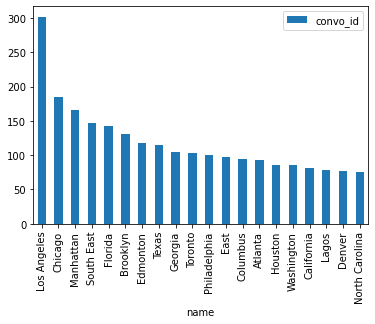

In [25]:
convo_places.groupby('name').agg('count').sort_values(by = 'convo_id', ascending=False).head(20).reset_index().plot(x = 'name', y = 'convo_id', kind='bar')

In [28]:
convo_places.groupby('name').agg('count').sort_values(by = 'convo_id', ascending=False).head(20).sum(0)

convo_id        2383
user_list       2383
tweet_list      2383
tweet_joined    2383
place_id        2383
id              2383
full_name       2383
country         2383
country_code    2383
type            2383
lat             2383
lon             2383
dtype: int64

## Clean Tweet Texts

In [66]:
re.sub(URL_regex, "", text_test)
re.sub(twitter_username_re, "", text_test)

' Including my SAP technology business.  Thank you. Namaste.'

In [82]:
# convo_places['tweet_joined'] = convo_places.tweet_list.apply(''.join)

In [123]:
def clean_text(text):
    temp = re.sub(URL_regex, "", text).strip()

    return re.sub(twitter_username_re, "", text)

convo_places['clean_convo'] = convo_places.tweet_joined.apply(clean_text)


In [127]:
convo_places['thread_length'] = convo_places['tweet_list'].apply(len)

In [129]:
convo_places = convo_places[convo_places.thread_length >= 3]

In [134]:
convo_places.groupby('name').agg('count').sort_values(by = 'convo_id', ascending=False)

convo_id         4177
user_list        4177
tweet_list       4177
tweet_joined     4177
place_id         4177
id               4177
full_name        4177
country          4177
country_code     4177
type             4177
lat              4177
lon              4177
clean_convo      4177
thread_length    4177
dtype: int64

In [135]:
convo_places.to_csv('convo_data.csv', index=False)